# Forecasting Macroeconomic variables with Neural Networks

## Abstract

 Econometrics has long been the lead forecasting method for many macro and micro variables and problems. Here we will use neural networks to see if they provide any advantage over the traditional use of econometrics and regression analysis. Preprocessing and making sure that we tune the parameters properly will play a big factor in whether our neural network can produce superior results over traditional econometrics. In this experiment we will create a neural network and compare it to some econometrics models to see if it's performance can surpass it.



## Variables

<br>
**CPI** *(Annual growth rate %)*

Inflation measured by consumer price index (CPI) is defined as the change in the prices of a basket of goods and services that are typically purchased by specific groups of households. Inflation is measured in terms of the annual growth rate and in index, 2010 base year with a breakdown for food, energy and total excluding food and energy. Inflation measures the erosion of living standards. A consumer price index is estimated as a series of summary measures of the period-to-period proportional change in the prices of a fixed set of consumer goods and services of constant quantity and characteristics, acquired, used or paid for by the reference population. Each summary measure is constructed as a weighted average of a large number of elementary aggregate indices. Each of the elementary aggregate indices is estimated using a sample of prices for a defined set of goods and services obtained in, or by residents of, a specific region from a given set of outlets or other sources of consumption goods and services.

**GDP** *(Percent Change same period previous year)*

Gross Domestic Product (GDP) is the standard measure of the value of final goods and services produced by a country during a period minus the value of imports. "Gross" signifies that no deduction has been made for the depreciation of machinery, buildings and other capital products used in production. "Domestic" means that it relates to the output produced on the economic territory of the country. The "products" refer to final goods and services, that is, those that are purchased, imputed or otherwise, as: the final consumption of households, non-profit institutions serving households and government; fixed capital formation; and exports (minus imports). GDP should not be looked upon as an all-encompassing measure for societies' well-being, as it does not include several aspects of people's material living standards let alone other aspects of people's quality of life. Data are internationally comparable by following the System of National Accounts. This indicator is seasonally adjusted and it is measured in percentage change from previous quarter and from same quarter previous year and based on real GDP.

**UR** *(Percent of labor force)*

Unemployment rate is the number of unemployed people as a percentage of the labour force, where the latter consists of the unemployed plus those in paid or self-employment. Unemployed people are those who report that they are without work, that they are available for work and that they have taken active steps to find work in the last four weeks. When unemployment is high, some people become discouraged and stop looking for work; they are then excluded from the labour force. This implies that the unemployment rate may fall, or stop rising, even though there has been no underlying improvement in the labour market.

**IR** - *Interest Rate (Immediate rates (< 24 hrs) Federal funds rate Percentage)*

Short-term interest rates are the rates at which short-term borrowings are effected between financial institutions or the rate at which short-term government paper is issued or traded in the market. Short-term interest rates are generally averages of daily rates, measured as a percentage. Short-term interest rates are based on three-month money market rates where available. Typical standardised names are "money market rate" and "treasury bill rate".

**LR10** - *Long-term government bond yields ()*



**CPI** *Growth rate same period previous year Percentage.*

Measures the price change in a basket for each item and averages them.

**GDP** *Growth rate same period previous year, s.a. Percentage*

Total value of goods produced and also the services provided during one year, hence the name "gross domestic product".

## Our Base Model
First we will make our base neural network, then improve upon it and lastly make our econometric model and compare the two.

In [2]:
# load our functions and objects
import numpy as np
from numpy import array
from numpy import hstack
from numpy import concatenate
import pandas as pd
from pandas import DataFrame
from pandas import concat
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import math
%matplotlib inline

def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

rcParams ['figure.figsize'] = 10, 10

Using TensorFlow backend.


In [3]:
# load data
macro = pd.read_csv("us_macro_var.csv")
# display data 
macro.head()

,TIME,CPI,GDP,UR,IR,LR10,LR10-IR,EXRATE
0,1998-Q1,1.462294,4.623460,4.633333,NaN,NaN,NaN,NaN
1,1998-Q2,1.602164,4.067661,4.400000,NaN,NaN,NaN,NaN
2,1998-Q3,1.595855,4.104639,4.533333,NaN,NaN,NaN,NaN
3,1998-Q4,1.548307,4.998974,4.433333,NaN,NaN,NaN,NaN
4,1999-Q1,1.667696,4.800728,4.300000,4.733333,0.25,4.983333,1.122667


In [4]:
# replace NA with median value
macro = macro.fillna(macro.median())
# turn time into row title instead of a variable
macro['TIME'] = pd.to_datetime(macro['TIME'])
macro = macro.set_index(['TIME'], drop=True)
macro.head(20)

,CPI,GDP,UR,IR,LR10,LR10-IR,EXRATE
TIME,,,,,,,
1998-01-01,1.462294,4.623460,4.633333,1.006667,1.901667,3.790000,1.251800
1998-04-01,1.602164,4.067661,4.400000,1.006667,1.901667,3.790000,1.251800
1998-07-01,1.595855,4.104639,4.533333,1.006667,1.901667,3.790000,1.251800
1998-10-01,1.548307,4.998974,4.433333,1.006667,1.901667,3.790000,1.251800
1999-01-01,1.667696,4.800728,4.300000,4.733333,0.250000,4.983333,1.122667
1999-04-01,2.109359,4.649637,4.266667,4.746667,0.793333,5.540000,1.056933
1999-07-01,2.345981,4.598207,4.233333,5.093333,0.790000,5.883333,1.049067
1999-10-01,2.622484,4.694708,4.066667,5.306667,0.833333,6.140000,1.038133
2000-01-01,3.240178,4.166983,4.033333,5.676667,0.803333,6.480000,0.986933


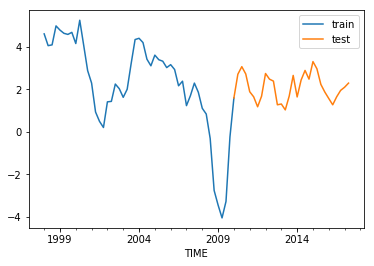

In [5]:
# let's split the data
split_date = pd.Timestamp('01-01-2010')

train = macro[['GDP']].loc[:split_date]
test = macro[['GDP']].loc[split_date:]
# plot our splti data
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

In [6]:
# reshape the data
sc = MinMaxScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [7]:
# split into train and test 
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [8]:
# process data for LSTM
X_tr = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [9]:
# setup LSTM network
model_lstm = Sequential()
model_lstm.add(LSTM(7, input_shape=(1, X_train.shape[1]), activation='relu', kernel_initializer='TruncatedNormal', return_sequences=False))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history_model_lstm = model_lstm.fit(X_tr, y_train, epochs=50, batch_size=2, verbose=1, shuffle=False)

Epoch 1/50
48/48 [==============================] - 1s 14ms/step - loss: 0.4894
Epoch 2/50
48/48 [==============================] - 0s 836us/step - loss: 0.4421
Epoch 3/50
48/48 [==============================] - 0s 831us/step - loss: 0.4008
Epoch 4/50
48/48 [==============================] - 0s 644us/step - loss: 0.3609
Epoch 5/50
48/48 [==============================] - 0s 812us/step - loss: 0.3211
Epoch 6/50
48/48 [==============================] - 0s 829us/step - loss: 0.2817
Epoch 7/50
48/48 [==============================] - 0s 688us/step - loss: 0.2431
Epoch 8/50
48/48 [==============================] - 0s 775us/step - loss: 0.2060
Epoch 9/50
48/48 [==============================] - 0s 826us/step - loss: 0.1711
Epoch 10/50
48/48 [==============================] - 0s 634us/step - loss: 0.1393
Epoch 11/50
48/48 [==============================] - 0s 827us/step - loss: 0.1112
Epoch 12/50
48/48 [==============================] - 0s 849us/step - loss: 0.0875
Epoch 13/50
48/48 [=======

In [61]:
# let's get our results
y_pred_test_lstm = model_lstm.predict(X_tst)
y_train_pred_lstm = model_lstm.predict(X_tr)
print("The R2 score on the train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))

r2_train = r2_score(y_train, y_train_pred_lstm)
print("The Adjusted R2 score on the train set is:\t{:0.3f}\n".format(adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))

print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))

r2_test = r2_score(y_test, y_pred_test_lstm)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))

The R2 score on the train set is:	0.616
The Adjusted R2 score on the train set is:	0.608

The R2 score on the Test set is:	0.227
The Adjusted R2 score on the Test set is:	0.199


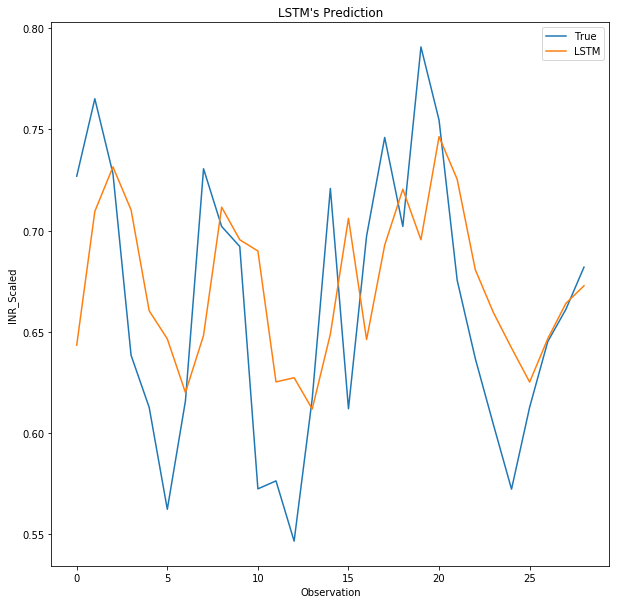

In [59]:
plt.plot(y_test, label='True')
plt.plot(y_pred_test_lstm, label='LSTM')
plt.title("LSTM's Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

### Baseline Model Conclusion

Here we have taken only the GDP data and tried to use LSTM to predict future GDP growth. As you can see from our $r^2$ value and from the graph we have done a poor job predicting the trend on the test data. Now we can improve this and in the next section we will use the other macroeconomic variables to help us predict GDP.  

## Econometrics Model